In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# from keras.preprocessing.image import img_to_array
# from keras.preprocessing.image import array_to_img
# from sklearn.model_selection import train_test_split
# from PIL import Image
# import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot
from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

# from tqdm import tqdm, tqdm_notebook
# from colorama import Fore
# import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
# import time
# from sklearn.decomposition import PCA
# from sklearn.svm import LinearSVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
# import lightgbm as lgb
# import xgboost as xgb
# !pip install livelossplot
# import livelossplot
# from livelossplot import PlotLossesKeras
import warnings
warnings.filterwarnings('ignore')
print("All modules have been imported")

All modules have been imported


In [8]:
!unzip ../input/diabetic-retinopathy-detection/trainLabels.csv.zip

Archive:  ../input/diabetic-retinopathy-detection/trainLabels.csv.zip
  inflating: trainLabels.csv         


## Importing labels

In [9]:
import pandas as pd

trainLabels = pd.read_csv("./trainLabels.csv")

In [10]:
!apt install p7zip-full -y
!7z x ../input/diabetic-retinopathy-detection/train.zip.001 "-i!train/11**.jpeg" -y # restrict extracted file to about 100 for the disk restriction
!mkdir big_data_new
!mv train big_data_new/train_1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  p7zip
Suggested packages:
  p7zip-rar
The following NEW packages will be installed:
  p7zip p7zip-full
0 upgraded, 2 newly installed, 0 to remove and 27 not upgraded.
Need to get 1545 kB of archives.
After this operation, 5896 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 p7zip amd64 16.02+dfsg-7build1 [358 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 p7zip-full amd64 16.02+dfsg-7build1 [1187 kB]
Fetched 1545 kB in 1s (1693 kB/s)   

78Selecting previously unselected package p7zip.
(Reading database ... 108086 files and directories currently installed.)
Preparing to unpack .../p7zip_16.02+dfsg-7build1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [ 11%] [######.........................................

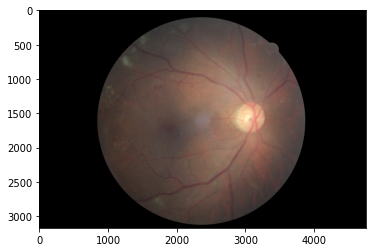

In [11]:
from PIL import Image

img = Image.open("./big_data_new/train_1/11923_right.jpeg")

import matplotlib.pyplot as plt

plt.imshow(img)

In [12]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Filtering csv file

In [13]:
import os
base_image_dir = os.path.join('.', 'big_data_new/train_1')
df = pd.read_csv(os.path.join('./trainLabels.csv'))
df['path'] = df['image'].map(lambda x: os.path.join(base_image_dir,'{}.jpeg'.format(x)))
df['exists'] = df['path'].map(os.path.exists) #Most of the files do not exist because this is a sample of the original dataset
df = df[df['exists']]
df = df.drop(columns=['image','exists'])
df = df.sample(frac=1).reset_index(drop=True)#shuffle dataframe
df['level'] = df['level'].astype(str)
df.head(10)

,level,path
0,2,./big_data_new/train_1/11863_left.jpeg
1,0,./big_data_new/train_1/11830_right.jpeg
2,0,./big_data_new/train_1/11157_left.jpeg
3,0,./big_data_new/train_1/11152_right.jpeg
4,0,./big_data_new/train_1/11438_right.jpeg
5,0,./big_data_new/train_1/11079_right.jpeg
6,0,./big_data_new/train_1/1116_left.jpeg
7,0,./big_data_new/train_1/11395_left.jpeg
8,0,./big_data_new/train_1/11750_left.jpeg
9,0,./big_data_new/train_1/11817_left.jpeg


### The dataset is highly imbalanced, with many samples for level 0, and very little for the rest of the levels.


<AxesSubplot:>

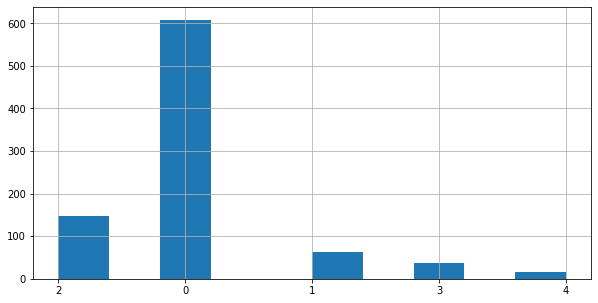

In [14]:
df['level'].hist(figsize = (10, 5))

In [15]:
def balance_data(class_size,df):
    train_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['level'].hist(figsize = (10, 5))
    return train_df


218

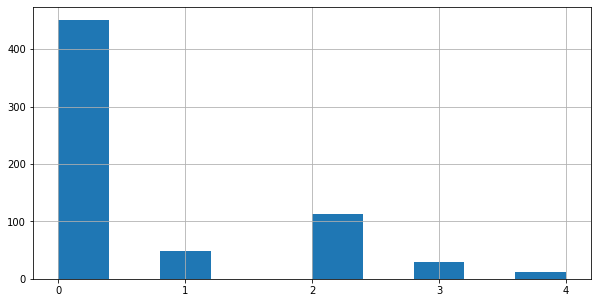

In [16]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df,test_size=0.25) # Here we will perform an 80%/20% split of the dataset, with stratification to keep similar distribution in validation set
train_df['level'].hist(figsize = (10, 5))
len(val_df)

New Data Size: 2255 Old Size: 654


<AxesSubplot:>

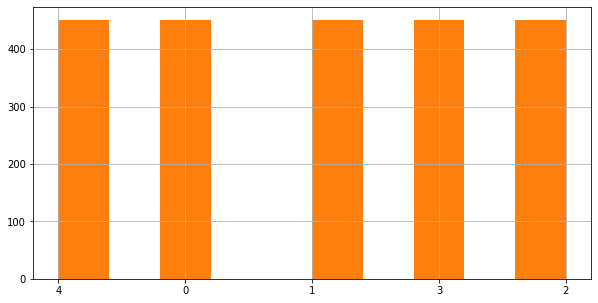

In [17]:
train_df = balance_data(train_df.pivot_table(index='level', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['level'].hist(figsize = (10, 5))

In [18]:
df = pd.concat([train_df,val_df]) #beginning of this dataframe is the oversampled training set, end is the validation set
len(df)

2473

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip = True,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split = 0.2
)

In [20]:
x_train = train_datagen.flow_from_dataframe(
        train_df,
        directory=".",
        x_col="path",
        y_col="level",
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')
x_test = test_datagen.flow_from_dataframe(
        val_df,
        x_col="path",
        y_col="level",
        directory=".",
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

Found 2255 validated image filenames belonging to 5 classes.
Found 218 validated image filenames belonging to 5 classes.


In [21]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Image Data Generator

In [22]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [23]:
t_x, t_y = next(x_train)


## Showing some pics

In [26]:
# plt.figure(figsize=(10, 10))
# for images, labels in x_train.take(1):
#   for i in range(6):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(classnames[labels[i]])
#     plt.axis("off")

## CNN Models

In [27]:
def create_CNN_model(model):
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(264,264,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

In [65]:
# def create_models(model_type):
#     model = Sequential()
#     if (model_type=="cnn"):
#         create_CNN_model(model)
#     elif(model_type == "resnet"):
#         pretrained_model= tf.keras.applications.ResNet50(include_top=False,
#                    input_shape=(256,256,3),
#                    pooling='avg',classes=5,
#                    weights='imagenet')
#         for layer in pretrained_model.layers:
#                 layer.trainable=False

#         model.add(pretrained_model)
#     elif(model_type == "googlenet"):
#         pretrained_model = tf.keras.applications.InceptionV3(
#                     include_top=True,
#                     weights="imagenet",
#                     input_shape=(299,299,3),
#                     pooling='avg',
#                     classes=1000)
#         for layer in pretrained_model.layers:
#                 layer.trainable=False
#         model.add(pretrained_model)
        
#     model.add(Flatten())
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(5, activation='softmax'))

#     model.compile(loss='categorical_crossentropy',
#                   optimizer=Adam(learning_rate=0.002),
#                   metrics=['accuracy',"AUC"])
#     return model;

from keras.applications.vgg16 import VGG16 as PTModel
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
from keras.applications.inception_v3 import InceptionV3 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = 2048
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(dr_steps)
model = Model(inputs = [in_lay], outputs = [out_layer])
from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 6, 6, 2048)   21802784    input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, 6, 6, 2048)   8192        inception_v3[0][0]               
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 6, 6, 2048)   0           batch_normalization_189[0][0]    
____________________________________________________________________________________________

In [29]:
# model = create_models("googlenet")

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 6, 6, 2048)   21802784    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 6, 6, 2048)   8192        inception_v3[0][0]               
__________________________________________________________________________________________________
dropout (Dropout)               (None, 6, 6, 2048)   0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

## Callbacks for Parameter Tuning

In [31]:
filepath = "dr-detector.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor="val_top2_accuracy",
                             verbose=1,
                             save_best_only=True,
                             mode="max")

earlystop = EarlyStopping(monitor='val_categorical_accuracy',
                          verbose=1, 
                          min_delta=0, 
                          patience=5, 
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              verbose=1,
                              factor=0.2, 
                              patience=5, 
                              min_delta=0.0001,
                              cooldown=0,
                              min_lr=0.001)


callbacks = [checkpoint, earlystop, reduce_lr]

In [32]:
history = model.fit(
        x_train,
        steps_per_epoch=x_train.samples // 64,
        epochs=50,
        validation_data=x_test,
        validation_steps=x_test.samples // 64,
        callbacks=callbacks)

2022-06-22 22:17:04.003950: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-06-22 22:17:12.837738: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


35/35 [==============================] - 173s 5s/step - loss: 1.1370 - categorical_accuracy: 0.5213 - top_2_accuracy: 0.7471 - val_loss: 2.4505 - val_categorical_accuracy: 0.1146 - val_top_2_accuracy: 0.2500
Epoch 2/50
35/35 [==============================] - 169s 5s/step - loss: 0.7579 - categorical_accuracy: 0.6899 - top_2_accuracy: 0.8767 - val_loss: 1.6506 - val_categorical_accuracy: 0.2396 - val_top_2_accuracy: 0.5625
Epoch 3/50
35/35 [==============================] - 171s 5s/step - loss: 0.6182 - categorical_accuracy: 0.7480 - top_2_accuracy: 0.9248 - val_loss: 1.5359 - val_categorical_accuracy: 0.3438 - val_top_2_accuracy: 0.6979
Epoch 4/50
35/35 [==============================] - 165s 5s/step - loss: 0.5140 - categorical_accuracy: 0.7911 - top_2_accuracy: 0.9411 - val_loss: 1.3273 - val_categorical_accuracy: 0.4167 - val_top_2_accuracy: 0.7708
Epoch 5/50
35/35 [==============================] - 159s 5s/step - loss: 0.4954 - categorical_accuracy: 0.7942 - top_2_accuracy: 0.9474

In [33]:
score = model.evaluate(x_train)
print(score)

71/71 [==============================] - 298s 4s/step - loss: 0.2530 - categorical_accuracy: 0.9242 - top_2_accuracy: 0.9894
[0.25303852558135986, 0.9241685271263123, 0.9893569946289062]


In [34]:
score_test = model.evaluate(x_test)
print(score_test)

7/7 [==============================] - 24s 3s/step - loss: 1.0618 - categorical_accuracy: 0.5826 - top_2_accuracy: 0.8578
[1.0617566108703613, 0.5825688242912292, 0.857798159122467]


In [35]:
history.history

{'loss': [1.1370484828948975,
  0.7579074501991272,
  0.6182308197021484,
  0.5139849781990051,
  0.49536991119384766,
  0.43970707058906555,
  0.3866352438926697,
  0.3952232301235199,
  0.34805819392204285,
  0.3166130781173706,
  0.28088265657424927,
  0.26136159896850586,
  0.2632530927658081],
 'categorical_accuracy': [0.521305501461029,
  0.6899365186691284,
  0.747960090637207,
  0.7910714149475098,
  0.7941976189613342,
  0.8267857432365417,
  0.8585675358772278,
  0.8422484397888184,
  0.8669642806053162,
  0.8776065111160278,
  0.8857142925262451,
  0.8955357074737549,
  0.9008928537368774],
 'top_2_accuracy': [0.7470535039901733,
  0.8766999244689941,
  0.9247506856918335,
  0.9410714507102966,
  0.9474161267280579,
  0.9624999761581421,
  0.9673617482185364,
  0.9718948602676392,
  0.9678571224212646,
  0.9728014469146729,
  0.9883928298950195,
  0.9750000238418579,
  0.9785714149475098],
 'val_loss': [2.4504852294921875,
  1.650634765625,
  1.5358866453170776,
  1.32727706

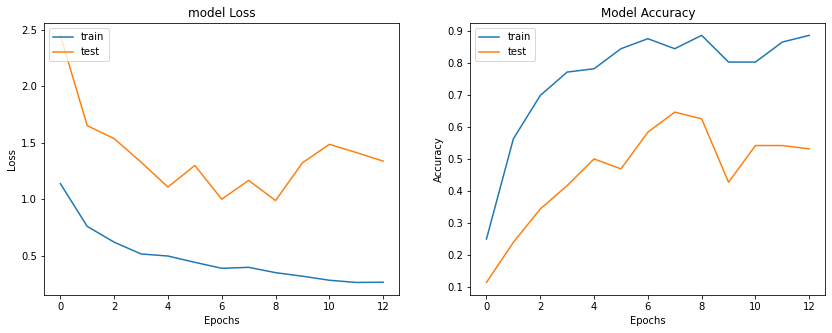

In [36]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history.history['val_top_2_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
model.save('/kaggle/working/Final_dr_model.h5')

In [ ]:
# Test Prediction helper function

In [75]:
def predict_dr(arg):
    if arg == 0:
        print("Normal")
    elif arg == 1:
        print("Mild")
    elif arg == 2:
        print("Moderate")
    elif arg == 3:
        print("Severe")
    elif arg == 4:
        print("Proliferate")

In [89]:
def image_prediction(path):
    from keras.models import load_model
    model = load_model("/kaggle/working/Final_dr_model.h5", custom_objects={"top_2_accuracy": top_2_accuracy})

    from PIL import Image

    img = Image.open(path)
    newsize = (256, 256)
    img = img.resize(newsize)

    import matplotlib.pyplot as plt

    plt.imshow(img)
    
    from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
    from keras.applications.vgg16 import preprocess_input

    #load the image
    my_image = load_img(path, target_size=(256, 256))

    #preprocess the image
    my_image = img_to_array(my_image)
    my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
    my_image = preprocess_input(my_image)

    #make the prediction
    prediction = model.predict(my_image)
    print(prediction)
    y_pred = np.argmax(prediction, axis=1)
    predict_dr(y_pred[0])
    

[[5.8044823e-12 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00]]
Proliferate


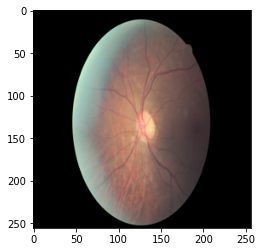

In [99]:
image_prediction("../input/drdatatest/10_left.jpeg")